In [31]:
#import packages
import pandas as pd
#removes false positive pandas warnings
pd.options.mode.chained_assignment = None  # default='warn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#importing sqlite and opening telecomDB database
import sqlite3 as db
con = db.connect('telecomDB.db')
c = con.cursor()

In [7]:
#Querying data from telecomDB and joining population by zip and churn datatables
customer_churn = pd.read_sql_query('''
                                    SELECT *
                                    FROM customer_churn
                                    INNER JOIN zipcode_population
                                         USING(ZipCode)
                                    ''', con)

print(customer_churn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     7043 non-null   object 
 1   Gender                         7043 non-null   object 
 2   Age                            7043 non-null   int64  
 3   Married                        7043 non-null   object 
 4   NumberofDependents             7043 non-null   int64  
 5   City                           7043 non-null   object 
 6   ZipCode                        7043 non-null   int64  
 7   Latitude                       7043 non-null   float64
 8   Longitude                      7043 non-null   float64
 9   NumberofReferrals              7043 non-null   int64  
 10  TenureinMonths                 7043 non-null   int64  
 11  Offer                          7043 non-null   object 
 12  PhoneService                   7043 non-null   o

In [84]:
#filtering for number of new customers in the last quarter
new_customers = pd.read_sql_query('''
                                    SELECT COUNT(CustomerID) AS new_members  
                                    FROM customer_churn
                                    WHERE CustomerStatus = 'Joined'
                                    ''', con)
print(new_customers)

#export to csv
new_customers.to_csv('new_customers.csv')

   new_members
0          454


In [55]:
#key drivers of customer churn
churned_customers_category = pd.read_sql_query('''
                                                SELECT ChurnCategory,
                                                        ChurnReason,
                                                        COUNT(CustomerID) AS number_churned
                                                FROM customer_churn
                                                WHERE CustomerStatus = 'Churned'
                                                GROUP BY ChurnCategory, ChurnReason
                                                ORDER BY COUNT(CustomerID) DESC
                                            ''', con)

print(churned_customers_category)

#export to csv
churned_customers_category.to_csv('customer_churn_by_category.csv')

      ChurnCategory                                ChurnReason  number_churned
0        Competitor              Competitor had better devices             313
1        Competitor               Competitor made better offer             311
2          Attitude                 Attitude of support person             220
3             Other                                 Don't know             130
4        Competitor               Competitor offered more data             117
5        Competitor  Competitor offered higher download speeds             100
6          Attitude               Attitude of service provider              94
7             Price                             Price too high              78
8   Dissatisfaction                    Product dissatisfaction              77
9   Dissatisfaction                        Network reliability              72
10            Price                      Long distance charges              64
11  Dissatisfaction                    Service dissa

    TenureinMonths  customer_loss  revenue_loss
0                1            380     83.020184
1                2            123     88.459675
2                3             94     90.469468
3                4             83     97.044096
4                5             64     93.794187
..             ...            ...           ...
67              68              9    124.321748
68              69              8    128.817065
69              70             11    118.537234
70              71              6    126.859507
71              72              6    114.577639

[72 rows x 3 columns]


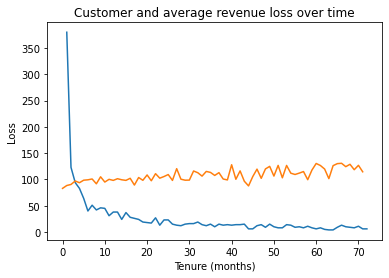

In [86]:
#customer and avg revenue loss over time
customer_churn_over_time = pd.read_sql_query("""
                                                SELECT TenureinMonths,
                                                       COUNT(CustomerID) AS customer_loss,
                                                       AVG(TotalRevenue)/TenureinMonths AS revenue_loss_per_person
                                                FROM customer_churn        
                                                WHERE CustomerStatus = 'Churned'        
                                                GROUP BY TenureinMonths
                                            """, con)

print(customer_churn_over_time)

#visualizing data
fig, ax = plt.subplots()
ax.plot(customer_churn_over_time['TenureinMonths'], customer_churn_over_time['customer_loss'], customer_churn_over_time['revenue_loss'])
ax.set_ylabel("Loss")
ax.set_xlabel('Tenure (months)')
ax.set_title("Customer and average revenue loss over time")
plt.show()

#export to csv
customer_churn_over_time.to_csv('customer_churn_over_time.csv')

In [57]:
#viewing customer churn and retention by contract type
customer_churn_contract = pd.read_sql_query("""
                                                SELECT CustomerStatus AS customer_status,
                                                        Contract AS contract_type,
                                                        COUNT(CustomerID) AS customer_count
                                                FROM customer_churn               
                                                GROUP BY CustomerStatus, Contract
                                            """, con)

print(customer_churn_contract)

#export to csv
customer_churn_contract.to_csv('customer_churn_contract.csv')

  customer_status   contract_type  customer_count
0         Churned  Month-to-Month            1655
1         Churned        One Year             166
2         Churned        Two Year              48
3          Joined  Month-to-Month             408
4          Joined        One Year              24
5          Joined        Two Year              22
6          Stayed  Month-to-Month            1547
7          Stayed        One Year            1360
8          Stayed        Two Year            1813


In [59]:
#offers and churn/join/retentioon
customer_churn_offer = pd.read_sql_query("""
                                                SELECT  CustomerStatus AS customer_status,
                                                        Offer AS offer_type,
                                                        COUNT(CustomerID) AS customer_count
                                                FROM customer_churn               
                                                GROUP BY CustomerStatus, Offer
                                            """, con)

print(customer_churn_offer)

#export to csv
customer_churn_offer.to_csv('customer_churn_offer.csv')

   customer_status offer_type  customer_count
0          Churned       None            1051
1          Churned    Offer A              35
2          Churned    Offer B             101
3          Churned    Offer C              95
4          Churned    Offer D             161
5          Churned    Offer E             426
6           Joined       None             279
7           Joined    Offer E             175
8           Stayed       None            2547
9           Stayed    Offer A             485
10          Stayed    Offer B             723
11          Stayed    Offer C             320
12          Stayed    Offer D             441
13          Stayed    Offer E             204


In [82]:
#viewing cities by churn rate
customer_churn_city = pd.read_sql_query("""
                                            SELECT  City,
                                                    COUNT(CustomerID) AS customer_count,
                                                    SUM(CASE
                                                            WHEN CustomerStatus = 'Churned' THEN 1
                                                            ELSE 0
                                                        END) AS customer_churn
                                            FROM customer_churn 
                                            GROUP BY City
                                            ORDER BY customer_churn DESC
                                            """, con)

print(customer_churn_city)

#export to csv
customer_churn_city.to_csv('customer_churn_city.csv')

               City  customer_count  customer_churn
0         San Diego             285             185
1       Los Angeles             293              78
2     San Francisco             104              31
3          San Jose             112              29
4        Sacramento             108              26
...             ...             ...             ...
1101    Aliso Viejo               4               0
1102         Albion               4               0
1103          Alamo               4               0
1104        Alameda               8               0
1105          Acton               4               0

[1106 rows x 3 columns]


In [70]:
#viewing potential new customers in each city
customer_potential_city = pd.read_sql_query('''
                                                SELECT City,
                                                        ZipCode,
                                                        Population,
                                                        COUNT(CustomerID),
                                                        COUNT(CustomerID)/Population AS percentage_of_market
                                                FROM customer_churn
                                                INNER JOIN zipcode_population
                                                         USING(ZipCode)
                                                WHERE CustomerStatus = 'Joined'
                                                        OR CustomerStatus = 'Stayed'
                                                GROUP BY City
                                            ''', con)
print(customer_potential_city)

              City  ZipCode  Population  COUNT(CustomerID)  \
0           Acampo    95220        6317                  1   
1            Acton    93510        7831                  4   
2         Adelanto    92301       18980                  4   
3             Adin    96006         615                  2   
4     Agoura Hills    91301       25303                  3   
...            ...      ...         ...                ...   
1093         Yreka    96097        9538                  4   
1094     Yuba City    95991       34967                  6   
1095       Yucaipa    92399       41575                  3   
1096  Yucca Valley    92284       20486                  5   
1097         Zenia    95595         259                  3   

      percentage_of_market  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
1093                     0  
1094                   